# Comparison of the content of the dataset documentation approaches

Before using add the "metadata-elements.xlsx" file in the "inputs" folder (see the README for details)

## Import required packages and set plot settings

In [2]:
import itertools
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [3]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]

## Load data

In [4]:
dfs = pd.read_excel(
    "inputs/dataset/primary/metadata-elements.xlsx", sheet_name=None
)
df_list = dfs["List"]
del dfs["List"]
del dfs["codebook"]
display(dfs["Datasheet"])
display(df_list)

,Question or field,Metadata element
0,For what purpose was the dataset created? Was ...,Description of the purpose for creating the da...
1,"Who created the dataset (e.g., which team, res...",Information about the creators of the dataset
2,Who funded the creation of the dataset? If the...,Details about the funding of the dataset
3,Any other comments?,NaN
4,What do the instances that comprise the datase...,Description of the instances included in the d...
...,...,...
61,"Will the dataset be updated (e.g., to correct ...",Description of the dataset update plan
62,"If the dataset relates to people, are there ap...",Description of the dataset retention policy
63,Will older versions of the dataset continue to...,Description of the management plan for older v...
64,If others want to extend/augment/build on/cont...,Description of the methods to contribute to th...


,Metadata element,isCritical
0,Description of the dataset,yes
1,Information about dataset audit/review,no
2,Information about the dataset versioning approach,no
3,Version of the dataset associated with this da...,yes
4,Information about the dataset documentation fo...,no
...,...,...
133,Link to design document,no
134,Description of the relevance of the data,no
135,Description and results of the requirement tes...,no
136,Description and results of the adversarial tes...,no


## Check if any metadata elements are too similar and should be regrouped into one

In [5]:
# Get a list of all metadata elements
metadata_elements_list = []
for sheet, df in dfs.items():
    metadata_elements_list += list(df["Metadata element"])
metadata_elements_list = [
    x for x in metadata_elements_list if str(x) != "nan"
]  # remove nan value
metadata_elements_list = [
    s.strip() for s in metadata_elements_list
]  # remove spaces ends of string
metadata_elements_list = list(set(metadata_elements_list))  # keep only unique entries

critical_df_list = df_list[df_list["isCritical"] == "yes"]
critical_metadata_elements_list = list(critical_df_list["Metadata element"])
df = pd.DataFrame(metadata_elements_list, columns=["Metadata element"])
# df.to_excel("outputs/metadata_elements_list.xlsx", index=False)
print("There are ", len(metadata_elements_list), " metadata elements")
print("There are ", len(critical_metadata_elements_list), " critical metadata elements")
display(df)

There are  138  metadata elements
There are  112  critical metadata elements


,Metadata element
0,Description of the data exclusion criteria
1,Version of the dataset associated with this da...
2,Description and results of the adversarial tes...
3,Description of issues related to this dataset
4,Number of subjects represented in the dataset
...,...
133,Required domain-specific knowledge for proper ...
134,Description of the elements that may impact fu...
135,Description of the data quality measurements
136,Description of the consent revocation mechanism


In [6]:
# Encode metadata elements
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(metadata_elements_list)

# Get and save cosine similarity scores
similar_rows = []
unique_index_pairs = list(
    itertools.combinations(list(range(len(metadata_elements_list))), 2)
)
for index_pair in unique_index_pairs:
    i = index_pair[0]
    j = index_pair[1]
    element1 = metadata_elements_list[i]
    element2 = metadata_elements_list[j]
    cosine_similarity = np.dot(embeddings[i], embeddings[j]) / (
        np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
    )
    similar_rows.append([element1, element2, cosine_similarity])
df_similar = pd.DataFrame(
    similar_rows, columns=["Element 1", "Element 2", "cosine similarity score"]
)
df_similar = df_similar.sort_values(by="cosine similarity score", ascending=False)
display(df_similar)
df_similar.to_excel("outputs/metadata_elements_similarity.xlsx", index=False)

,Element 1,Element 2,cosine similarity score
172,Version of the dataset associated with this da...,Information about the dataset documentation fo...,0.954538
2672,Description of the undesirable uses of the dat...,Description of the intended use of the dataset,0.908756
3368,Description of the intended use of the dataset,Description of the purpose for creating the da...,0.896263
4438,Information about the dataset documentation fo...,Information about the authors of this dataset ...,0.877440
208,Version of the dataset associated with this da...,Information about the authors of this dataset ...,0.868454
...,...,...,...
7179,Link to design document,Description of the dataset retention policy,-0.096966
703,Description of other transformations,Recommendations when sampling the dataset,-0.099885
3280,Assumption in data fields not made explicit in...,Link to design document,-0.106389
2026,Last update date,Description of the strategies to avoid undesir...,-0.114775


Note: We ran this on the first version of our metadata element assignment where we had 146 unique metadata elements. We manually reviewed each pair of elements in descending order of cosine similarity value. We noticed that below a similarity score of 0.75, the elements were not similar and therefore we did not manually check below that. We identified 7 pairs of metadata elements that could be regrouped into one and ended up with a total of 139 unique metadata elements after that.

## View metadata elements and related questions/fields side-by-side for further review

In [7]:
documentation_list = list(dfs.keys())
retrouped_list = []
for metadata_element in metadata_elements_list:
    dict_questions = {}
    for sheet, df in dfs.items():
        df = df.loc[df["Metadata element"] == metadata_element]
        dict_questions[sheet] = list(df["Question or field"])
    count = 0
    not_all_nan = True
    while not_all_nan:
        row = []
        if count == 0:
            row.append(metadata_element)
        else:
            row.append(math.nan)
        for sheet in documentation_list:
            sheet_list = dict_questions[sheet]
            if len(sheet_list) > count:
                row.append(sheet_list[count])
            else:
                row.append(math.nan)
        if all(i != i for i in row):
            not_all_nan = False
        else:
            retrouped_list.append(row)
        count += 1
df_regrouped = pd.DataFrame(
    retrouped_list, columns=["Metadata element"] + documentation_list
)
display(df_regrouped)
df_regrouped.to_excel(
    "outputs/metadata_elements_regrouped_all_documentation_approaches.xlsx", index=False
)

,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card
0,Description of the data exclusion criteria,NaN,NaN,NaN,NaN,Summarize the data exclusion criteria.\n\nUse ...
1,Version of the dataset associated with this da...,NaN,Indicate which version of the dataset is being...,NaN,Is this datasheet created for the original ver...,Provide details about this version of the data...
2,Description and results of the adversarial tes...,NaN,NaN,Adversarial test (Describe tests),NaN,NaN
3,NaN,NaN,NaN,Results (Score or Results),NaN,NaN
4,NaN,NaN,NaN,Artifact: (Justification of the results or a l...,NaN,NaN
...,...,...,...,...,...,...
301,Description and results of the requirement tes...,NaN,NaN,Requirement tested: ( Requirement from require...,NaN,NaN
302,NaN,NaN,NaN,Results (Score or Results),NaN,NaN
303,NaN,NaN,NaN,Artifact (Justification of the results or a li...,NaN,NaN
304,NaN,NaN,NaN,Untested Requirement ( Requirement from requir...,NaN,NaN


## Analysis

### Comparison matrix

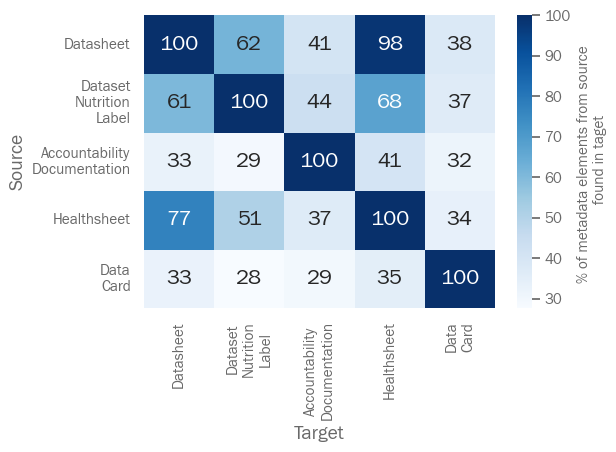

In [8]:
df_comparison = pd.DataFrame(
    index=list(dfs.keys()), columns=list(dfs.keys()), dtype=float
)
for documentation1 in df_comparison.index:
    df1 = dfs[documentation1]
    for documentation2 in df_comparison.columns:
        df2 = dfs[documentation2]
        df_comparison.loc[documentation1, documentation2] = (
            len(
                [
                    i
                    for i in list(df1["Metadata element"])
                    if i in list(df2["Metadata element"])
                ]
            )
            / len(list(df1["Metadata element"]))
            * 100
        )
labels = []
for doc in dfs.keys():
    if len(doc.split()) > 1:
        doc = "\n".join(doc.split())
    labels.append(doc)

df_comparison.to_excel("outputs/metadata_elements_comparison_matrix.xlsx", index=False)
ax = sns.heatmap(
    df_comparison,
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
    cmap="Blues",
    fmt="0.0f",
    cbar_kws={"label": "% of metadata elements from source \n found in taget"},
)
ax.figure.axes[-1].yaxis.label.set_size(11)
ax.set_xlabel("Target", fontsize=14)
ax.set_ylabel("Source", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/metadata_elements_comparison_matrix.png", dpi=200)

### Occurence of metadata elements accross dataset documentation

In [9]:
elements_count_list = []
for metadata_element in metadata_elements_list:
    row = [metadata_element]
    for sheet, df in dfs.items():
        if metadata_element in list(df["Metadata element"]):
            row.append("yes")
        else:
            row.append("no")
    row.append(len([i for i in row if i == "yes"]))
    if metadata_element in critical_metadata_elements_list:
        row.append("yes")
    else:
        row.append("no")
    elements_count_list.append(row)
df_element_count = pd.DataFrame(
    elements_count_list,
    columns=["Metadata element"] + list(dfs.keys()) + ["Count", "Critical"],
)
df_element_count = df_element_count.sort_values(by=["Count"], ascending=False)
df_element_count.to_excel("outputs/metadata_elements_count.xlsx", index=False)
display(df_element_count)

,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
27,Description of the intended use of the dataset,yes,yes,yes,yes,yes,5,yes
23,Description of the dataset update plan,yes,yes,yes,yes,yes,5,yes
60,Description of the dataset sharing method,yes,yes,yes,yes,yes,5,yes
83,Description of the data collection process,yes,yes,yes,yes,yes,5,yes
129,Details about the funding of the dataset,yes,yes,yes,yes,yes,5,yes
...,...,...,...,...,...,...,...,...
127,Definition of the acronyms and concepts used i...,no,no,no,no,yes,1,yes
133,Required domain-specific knowledge for proper ...,no,yes,no,no,no,1,yes
132,Recommendations when used in AI/ML systems,no,no,no,no,yes,1,yes
135,Description of the data quality measurements,no,no,yes,no,no,1,yes


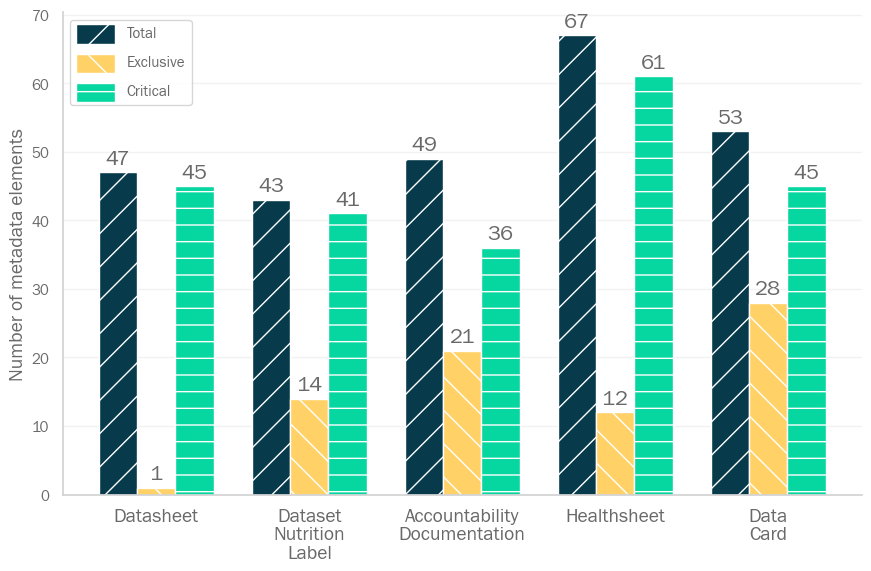

In [13]:
## Number of metadata elements and unique metadata elements per dataset documentation approach
count_metadata_elements = []
count_unique_metadata_elements = []
count_missing_critical_metadata_elements = []
labels = []
for doc in list(dfs.keys()):
    count_metadata_elements.append(df_element_count[doc].value_counts().get("yes", 0))
    count_unique_metadata_elements.append(
        len(
            df_element_count[
                (df_element_count[doc] == "yes") & (df_element_count["Count"] == 1)
            ]
        )
    )
    count_missing_critical_metadata_elements.append(
        len(
            df_element_count[
                (df_element_count[doc] == "yes")
                & (df_element_count["Critical"] == "yes")
            ]
        )
    )
    if len(doc.split()) > 1:
        doc = "\n".join(doc.split())
    labels.append(doc)

# plot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

width = 0.25
y_list = [
    count_metadata_elements,
    count_unique_metadata_elements,
    count_missing_critical_metadata_elements,
]
labels_list = ["Total", "Exclusive", "Critical"]
x = np.arange(len(labels))
count = 0
for y in y_list:
    bars = ax.bar(
        x + width * count,
        y,
        width,
        color=colors[count],
        hatch=patterns[count],
        label=labels_list[count],
    )
    ax.bar_label(bars, padding=3)
    count += 1

ax.set_xticks(x + width, labels, fontsize=14)
ax.set_ylabel("Number of metadata elements", fontsize=14)
ax.set_axisbelow(True)
leg = ax.legend(loc="upper left", labelspacing=1, handlelength=2.5, facecolor="white")
for patch in leg.get_patches():
    patch.set_height(14)
    patch.set_y(-5)
ax.grid(axis="y", color="0.95")
plt.grid(color="0.95", axis="y")

fig.tight_layout()
fig.savefig("outputs/metadata_elements_view.png", dpi=200)

In [11]:
df_common = df_element_count[df_element_count["Count"] == 5]
df_unique = df_element_count[df_element_count["Count"] == 1]
print(
    "There are",
    len(df_common),
    "metadata elements that are found in all five documentation approaches",
)
print(
    "There are",
    len(df_unique),
    "metadata elements that are found exclusively in one of the five documentation approaches",
)
display(df_common)

There are 7 metadata elements that are found in all five documentation approaches
There are 76 metadata elements that are found only in one of the five documentation approaches


,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
27,Description of the intended use of the dataset,yes,yes,yes,yes,yes,5,yes
23,Description of the dataset update plan,yes,yes,yes,yes,yes,5,yes
60,Description of the dataset sharing method,yes,yes,yes,yes,yes,5,yes
83,Description of the data collection process,yes,yes,yes,yes,yes,5,yes
129,Details about the funding of the dataset,yes,yes,yes,yes,yes,5,yes
120,Information about the owners of the dataset,yes,yes,yes,yes,yes,5,yes
58,Dataset publication date,yes,yes,yes,yes,yes,5,yes


In [12]:
# Least common
for dataset_documentation in dfs.keys():
    print("----- Unique metadata description in " + dataset_documentation + " -----")
    df_unique = df_element_count[
        (df_element_count["Count"] == 1)
        & (df_element_count[dataset_documentation] == "yes")
    ]
    display(df_unique)

----- Unique metadata description in Datasheet -----


,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
122,Description of the possibilities to identify i...,yes,no,no,no,no,1,yes


----- Unique metadata description in Dataset Nutrition Label -----


,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
3,Description of issues related to this dataset,no,yes,no,no,no,1,yes
8,Keywords,no,yes,no,no,no,1,yes
71,Information about the people consulted to crea...,no,yes,no,no,no,1,yes
66,Description of representation issues in the data,no,yes,no,no,no,1,yes
43,Description of the individual-level data,no,yes,no,no,no,1,no
26,Assumption in data fields not made explicit in...,no,yes,no,no,no,1,yes
40,Information about the format/structure of the ...,no,yes,no,no,no,1,yes
99,Information about the metadata repository and ...,no,yes,no,no,no,1,yes
92,Description of the strategies to avoid undesir...,no,yes,no,no,no,1,yes
77,Description of the involvement of the particip...,no,yes,no,no,no,1,yes


----- Unique metadata description in Accountability Documentation -----


,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
2,Description and results of the adversarial tes...,no,no,yes,no,no,1,no
6,Link to requirements specification,no,no,yes,no,no,1,no
15,Last update date,no,no,yes,no,no,1,yes
70,Link to design document,no,no,yes,no,no,1,no
63,Expectations for people using the dataset,no,no,yes,no,no,1,no
44,Description of the ethical impact of the data ...,no,no,yes,no,no,1,yes
50,Description of the relevance of the data,no,no,yes,no,no,1,no
53,Description of related datasets,no,no,yes,no,no,1,no
52,List of related documents,no,no,yes,no,no,1,yes
54,Description of the privacy handling,no,no,yes,no,no,1,yes


----- Unique metadata description in Healthsheet -----


,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
4,Number of subjects represented in the dataset,no,no,no,yes,no,1,yes
7,Description of the accessibility measurements,no,no,no,yes,no,1,yes
16,Description of the confounding factors that mi...,no,no,no,yes,no,1,yes
12,Description of the strategies to avoid reident...,no,no,no,yes,no,1,yes
11,Guidelines for creating new labels,no,no,no,yes,no,1,yes
59,Countries where the data was collected,no,no,no,yes,no,1,yes
45,Description of the regulation preventing demog...,no,no,no,yes,no,1,yes
25,Information about the dataset versioning approach,no,no,no,yes,no,1,no
14,Description of the choice(s) of language for c...,no,no,no,yes,no,1,yes
37,Information about the dataset documentation fo...,no,no,no,yes,no,1,no


----- Unique metadata description in Data Card -----


,Metadata element,Datasheet,Dataset Nutrition Label,Accountability Documentation,Healthsheet,Data Card,Count,Critical
0,Description of the data exclusion criteria,no,no,no,no,yes,1,yes
5,Description of other transformations,no,no,no,no,yes,1,no
64,Description of the prerequisites to access thi...,no,no,no,no,yes,1,yes
42,Description of annotations,no,no,no,no,yes,1,yes
47,Description and handling of mismatched values,no,no,no,no,yes,1,yes
55,Information about the first version of the dat...,no,no,no,no,yes,1,no
19,Description of the joint inputs sourced,no,no,no,no,yes,1,yes
18,Description of the data validation process,no,no,no,no,yes,1,yes
28,Description of the human data attributes,no,no,no,no,yes,1,yes
30,Description and handling of the outliers,no,no,no,no,yes,1,yes
